<h1>Description of the problem</h1> 

>A bit of **background**: in the digital marketing world it is really important to retain the customers (not to let them *churn* / unsubscribe). Most big companies have churn prediction models which are based on customer data. Attached is a dataset for a mobile company in which different features of each customer are shown (in different columns), and in the last column you can see if they churned or not.

We have a dataset from a mobile company including a few hundred customers. For each customer, we have some features (gender, tenure, etc.) and we know if they have churned or not. The goal of this project is to see if by looking at the value of these features, we can learn a model that will predict whether a customer will leave (churn) or stay. This is an example of **supervised machine learning** project. All supervised algorithms have some features and related target/label values. This problem is also a binary classification because our target is either someone who has churned or not.   

The focus of the project is to build a churn predictive model. 
Here, are the major steps that we will take: 
1. Data exploration and visualization
2. Data cleaning / pre-processing
3. Choice of predictive model and features
4. Use CV to train and evaluate our model
5. Description of outcomes / conclusion

## 0. Preliminaries

In [161]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 1. Data exploration

In [162]:
# load dataset
ds = pd.read_csv('churn.csv')
display(ds.head())
print(ds.shape)
print(ds.columns)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


(7043, 21)
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [163]:
# dataset summary for numeric variables
ds.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [164]:
# look for nan and null
print(ds.isnull().values.any())

False


In [165]:
# Check how many people ended up churning
left = ds[ds.Churn=='Yes']
stay = ds[ds.Churn=='No']
print("Number of people who left:", left['Churn'].count())
print("Number of people who stayed:", stay['Churn'].count())

Number of people who left: 1869
Number of people who stayed: 5174


Churn
No     [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
Yes    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
dtype: object

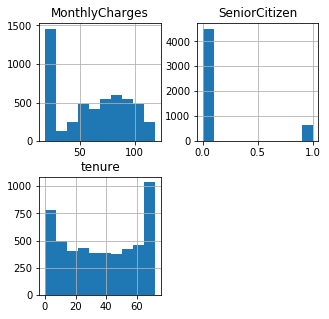

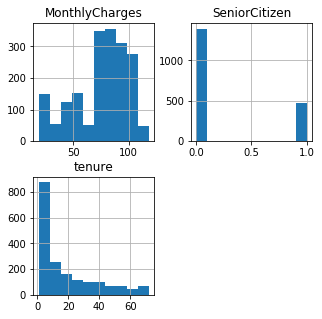

In [166]:
# Plot exploratory histograms for numeric variables, separately for stay or left
ds.groupby('Churn').hist(figsize=(5, 5))

## 2. Pre-processing

In [167]:
# Let's turn string variables into numeric ones
ds['genderID'] = np.double(ds.gender=='Female')
ds['partnerID'] = np.double(ds.Partner=='Yes')
ds['dependentsID'] = np.double(ds.Dependents=='Yes')
ds['phoneservID'] = np.double(ds.PhoneService=='Yes')

ds.loc[ds[ds.MultipleLines=='No phone service'].index, 'multlinesID'] = -1
ds.loc[ds[ds.MultipleLines=='No'].index, 'multlinesID'] = 0
ds.loc[ds[ds.MultipleLines=='Yes'].index, 'multlinesID'] = 1

ds.loc[ds[ds.InternetService=='No'].index, 'internetID'] = -1
ds.loc[ds[ds.InternetService=='DSL'].index, 'internetID'] = 1
ds.loc[ds[ds.InternetService=='Fiber optic'].index, 'internetID'] = 2

ds.loc[ds[ds.OnlineSecurity=='No internet service'].index, 'securityID'] = -1
ds.loc[ds[ds.OnlineSecurity=='No'].index, 'securityID'] = 0
ds.loc[ds[ds.OnlineSecurity=='Yes'].index, 'securityID'] = 1

ds.loc[ds[ds.OnlineBackup=='No internet service'].index, 'backupID'] = -1
ds.loc[ds[ds.OnlineBackup=='No'].index, 'backupID'] = 0
ds.loc[ds[ds.OnlineBackup=='Yes'].index, 'backupID'] = 1

ds.loc[ds[ds.DeviceProtection=='No internet service'].index, 'devprotID'] = -1
ds.loc[ds[ds.DeviceProtection=='No'].index, 'devprotID'] = 0
ds.loc[ds[ds.DeviceProtection=='Yes'].index, 'devprotID'] = 1

ds.loc[ds[ds.TechSupport=='No internet service'].index, 'techsuppID'] = -1
ds.loc[ds[ds.TechSupport=='No'].index, 'techsuppID'] = 0
ds.loc[ds[ds.TechSupport=='Yes'].index, 'techsuppID'] = 1

ds.loc[ds[ds.StreamingTV=='No internet service'].index, 'streamtvID'] = -1
ds.loc[ds[ds.StreamingTV=='No'].index, 'streamtvID'] = 0
ds.loc[ds[ds.StreamingTV=='Yes'].index, 'streamtvID'] = 1

ds.loc[ds[ds.StreamingMovies=='No internet service'].index, 'streammovID'] = -1
ds.loc[ds[ds.StreamingMovies=='No'].index, 'streammovID'] = 0
ds.loc[ds[ds.StreamingMovies=='Yes'].index, 'streammovID'] = 1

ds.loc[ds[ds.Contract=='Month-to-month'].index, 'contractID'] = 0
ds.loc[ds[ds.Contract=='One year'].index, 'contractID'] = 1
ds.loc[ds[ds.Contract=='Two year'].index, 'contractID'] = 2

ds['paperlessID'] = np.double(ds.PaperlessBilling=='Yes')

ds.loc[ds[ds.PaymentMethod=='Bank transfer (automatic)'].index, 'paymentID'] = 1
ds.loc[ds[ds.PaymentMethod=='Credit card (automatic)'].index, 'paymentID'] = 2
ds.loc[ds[ds.PaymentMethod=='Electronic check'].index, 'paymentID'] = 3
ds.loc[ds[ds.PaymentMethod=='Mailed check'].index, 'paymentID'] = 4

ds['churnID'] = np.double(ds.Churn=='Yes')

# Let's drop some features that are not useful
ds = ds.drop(columns=['customerID'])

# Let's save the new clean dataset
ds.to_csv('churn_clean.csv')

churnID
0.0    [[AxesSubplot(0.125,0.758226;0.158163x0.121774...
1.0    [[AxesSubplot(0.125,0.758226;0.158163x0.121774...
dtype: object

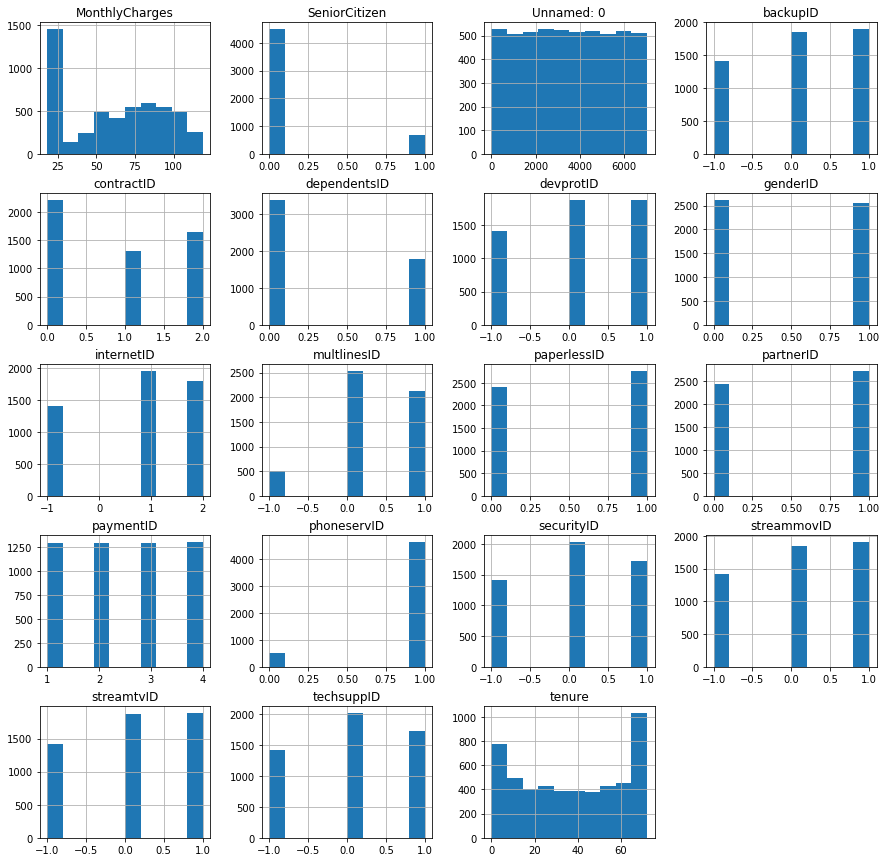

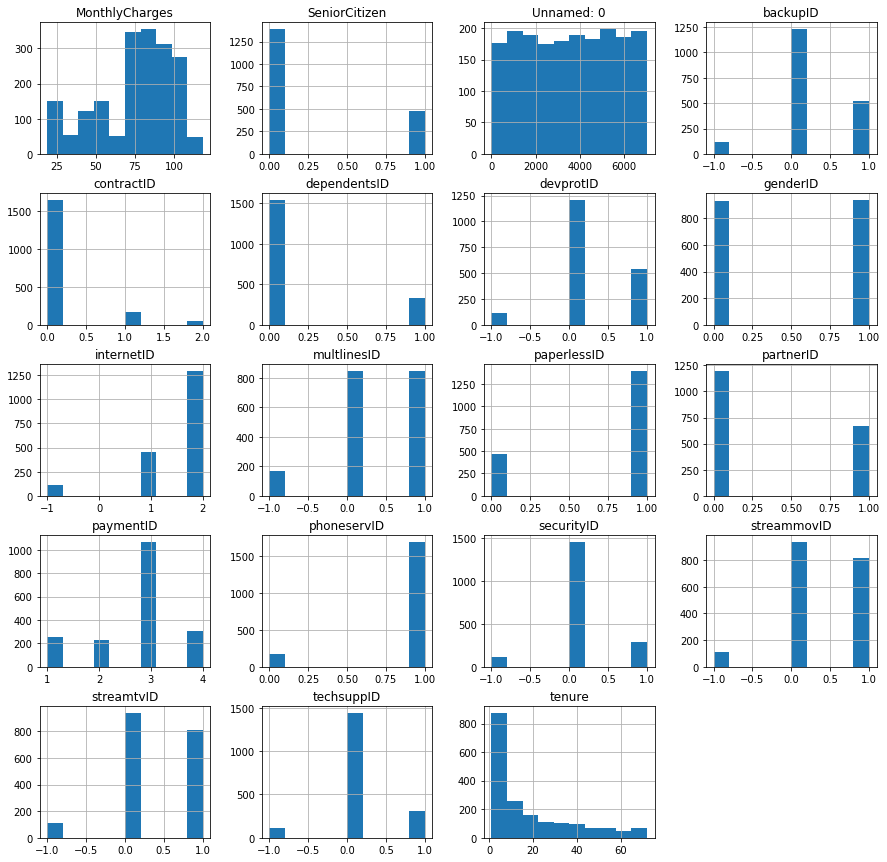

In [170]:
# Now import clean dataset
df = pd.read_csv('churn_clean.csv')

# Re-explore features
df.groupby('churnID').hist(figsize=(15, 15))

## 3. Feature selection

## 4. Model evaluation

## 5. Conclusions